In [183]:
import pandas as pd  # For data handling
import numpy as np  # For numerical operations
import seaborn as sns

In [185]:
file_path="C:\\Users\\sujin\\Downloads\\energydata_complete.csv"
df = pd.read_csv(file_path)

In [187]:
df['date']=pd.to_datetime(df['date'])
df['hour']=df['date'].dt.hour
df['day_of_week']=df['date'].dt.dayofweek
df['month']=df['date'].dt.month
df.drop(columns=['date'], inplace=True)

In [189]:
df.drop(columns=['rv1','rv2'],inplace=True)

In [191]:
print("Missing values per column before dropping:\n", df.isnull().sum())
df.dropna(inplace=True)  # Drop rows with missing values
print("Dataset shape after dropping missing values:", df.shape)

Missing values per column before dropping:
 Appliances     0
lights         0
T1             0
RH_1           0
T2             0
RH_2           0
T3             0
RH_3           0
T4             0
RH_4           0
T5             0
RH_5           0
T6             0
RH_6           0
T7             0
RH_7           0
T8             0
RH_8           0
T9             0
RH_9           0
T_out          0
Press_mm_hg    0
RH_out         0
Windspeed      0
Visibility     0
Tdewpoint      0
hour           0
day_of_week    0
month          0
dtype: int64
Dataset shape after dropping missing values: (19735, 29)


In [193]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
LOWER = Q1 - 1.5 * IQR
UPPER = Q3 + 1.5 * IQR

def cap_outliers(value, lower, upper):
    return np.where(value < lower, lower, np.where(value > upper, upper, value))

for col in df.columns:
    if df[col].dtype != 'object':
        df[col] = cap_outliers(df[col], LOWER[col], UPPER[col])

print(f"Data shape after outlier capping: {df.shape}")


Data shape after outlier capping: (19735, 29)


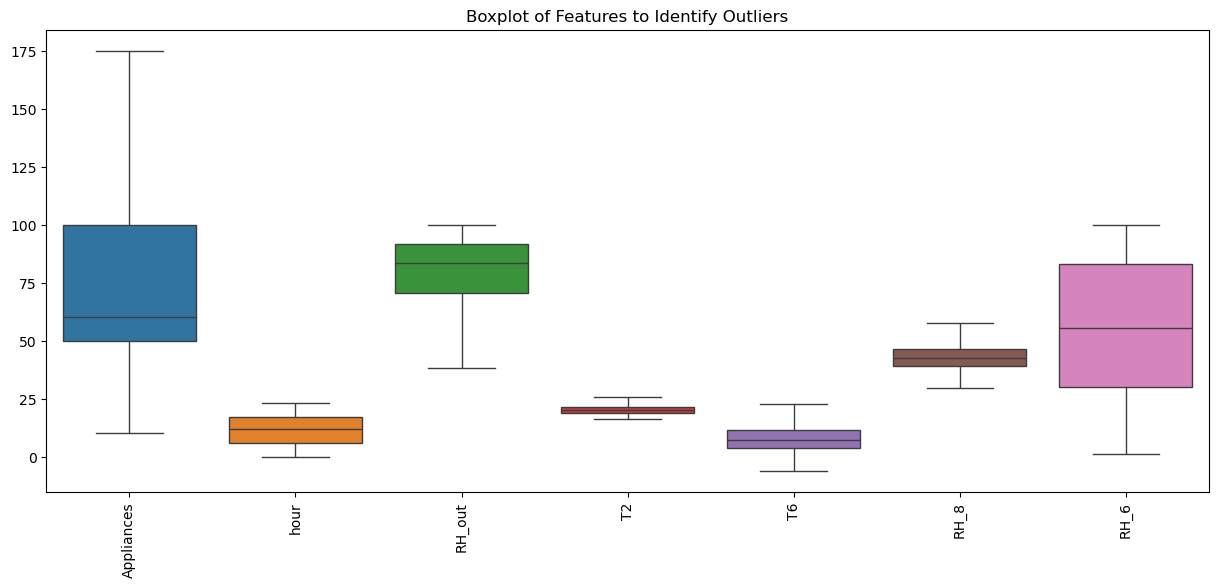

In [213]:
plt.figure(figsize=(15, 6))
sns.boxplot(data=df)
plt.xticks(rotation=90)
plt.title("Boxplot of Features to Identify Outliers")
plt.show()

In [199]:
from sklearn.model_selection import train_test_split
X = df.drop(columns=['Appliances'])  # Features
y = df['Appliances']  # Target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [201]:
import matplotlib.pyplot as plt 
from sklearn.preprocessing import RobustScaler 

In [205]:
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)  # Fit & transform training data
X_test = scaler.transform(X_test)  # Transform test data using the same scaler


In [250]:
print(f"Dataset shape after preprocessing: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

Dataset shape after preprocessing: (15788, 6)
Test set shape: (3947, 6)


In [254]:
from sklearn.linear_model import LinearRegression  # Linear Regression Model
from sklearn.ensemble import RandomForestRegressor  # Random Forest Model
from sklearn.svm import SVR  # Support Vector Regression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score  # Evaluation metrics


In [280]:
# Train Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)

# Train Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

# Train Support Vector Regression
svr_model = SVR()
svr_model.fit(X_train, y_train)
svr_pred = svr_model.predict(X_test)

results = {
    "Linear Regression": {
        "MAE": mean_absolute_error(y_test, lr_pred),
        "MSE": mean_squared_error(y_test, lr_pred),
        "RMSE": np.sqrt(mean_squared_error(y_test, lr_pred)),
        "R2 Score": r2_score(y_test, lr_pred)
    },
    "Random Forest": {
        "MAE": mean_absolute_error(y_test, rf_pred),
        "MSE": mean_squared_error(y_test, rf_pred),
        "RMSE": np.sqrt(mean_squared_error(y_test, rf_pred)),
        "R2 Score": r2_score(y_test, rf_pred)
    },
    "Support Vector Regression": {
        "MAE": mean_absolute_error(y_test, svr_pred),
        "MSE": mean_squared_error(y_test, svr_pred),
        "RMSE": np.sqrt(mean_squared_error(y_test, svr_pred)),
        "R2 Score": r2_score(y_test, svr_pred)
    }
}


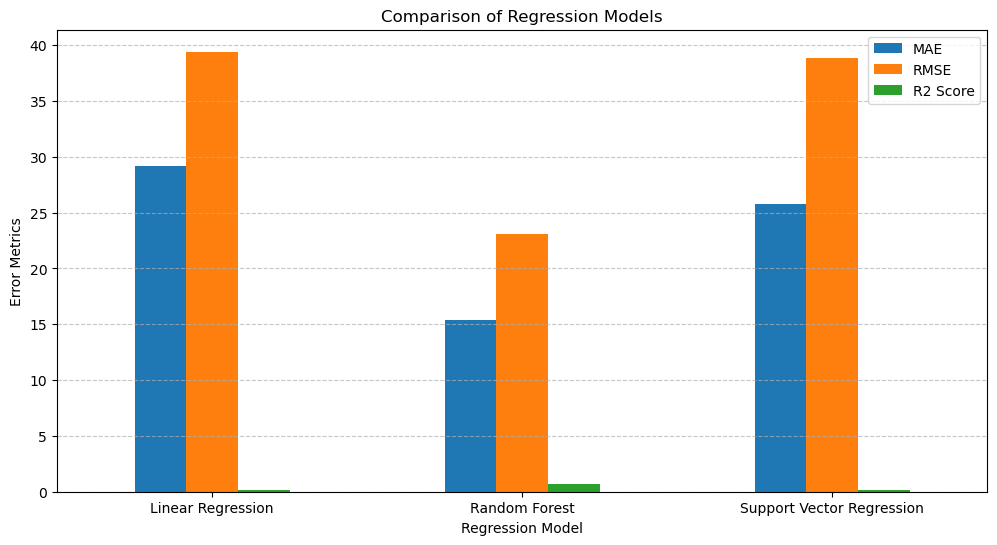

In [276]:
metrics_df = pd.DataFrame(results).T
metrics_df = metrics_df[['MAE', 'RMSE', 'R2 Score']]  # Order the columns

# Plot performance comparison
metrics_df.plot(kind='bar', figsize=(12, 6))
plt.title("Comparison of Regression Models")
plt.xlabel("Regression Model")
plt.ylabel("Error Metrics")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.show()

In [282]:
for model, metrics in results.items():
    print(f"{model} Performance:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")
    print("-" * 40)

Linear Regression Performance:
MAE: 29.1989
MSE: 1554.0272
RMSE: 39.4212
R2 Score: 0.1545
----------------------------------------
Random Forest Performance:
MAE: 15.3592
MSE: 534.1450
RMSE: 23.1116
R2 Score: 0.7094
----------------------------------------
Support Vector Regression Performance:
MAE: 25.8133
MSE: 1508.1919
RMSE: 38.8354
R2 Score: 0.1794
----------------------------------------


In [284]:
best_model_name = max(results, key=lambda model: results[model]['R2 Score'])
best_model = rf_model if best_model_name == "Random Forest" else (lr_model if best_model_name == "Linear Regression" else svr_model)
print(f"Best Performing Model: {best_model_name}")

Best Performing Model: Random Forest


   Actual  Predicted
0    40.0      53.00
1    90.0      94.65
2    50.0      42.80
3    50.0      63.20
4    70.0      84.80
5   120.0     139.40
6   120.0     110.50
7    70.0      70.50
8    50.0      50.80
9    70.0      85.25


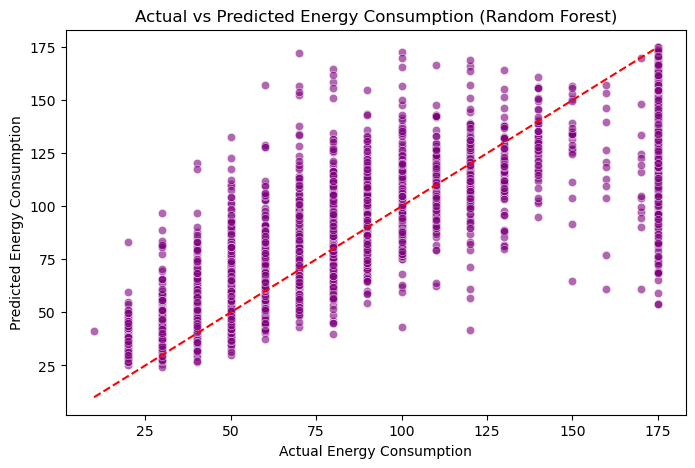

In [298]:
# Predict energy consumption using Random Forest
rf_pred = rf_model.predict(X_test)

# Create DataFrame to compare actual vs. predicted values
rf_results_df = pd.DataFrame({'Actual': y_test.values, 'Predicted': rf_pred})

print(rf_results_df.head(10))

# Scatter plot for Actual vs. Predicted
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_test, y=rf_pred, alpha=0.6, color="purple")
plt.xlabel('Actual Energy Consumption')
plt.ylabel('Predicted Energy Consumption')
plt.title('Actual vs Predicted Energy Consumption (Random Forest)')

# Reference line for perfect predictions
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')

plt.show()
